In [1]:
import os
os.environ["GEOMSTATS_BACKEND"] = 'autograd'

In [2]:
import geomstats
import math
import geomstats.backend as gs
from geomstats.geometry.spd_matrices import *
from geomstats.geometry.lie_group import *
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla
from denoising_geodesic import DenoisingGeodesic
from geomstats.geometry.general_linear import GeneralLinear
from geomstats.geometry.symmetric_matrices import SymmetricMatrices
from shape_project import *

INFO: Using autograd backend


# Learning distributions of healthy & schizophrenic brain shapes via denoising diffusion on manifolds.
## Authors: Marianne Arriola & Ryan Stofer

### Introduction and Background:
(Ryan)

#### What is Schizophrenia and why do we care?
According to the WHO, Schizophrenia is classified as a mental disorder which impairs a person's ability to think, feel and behave properly. Schizophrenia currently affects approximately 24 million people or 1 in 300 people (0.32%) worldwide and those who are infected with the disease are 2 to 3 times more likely to die early than the general population [1].

#### What data are we using?
 - Kaggle's MLSP 2014 Schizophrenia Classification Challenge [2]
 - Functional Network Connectivity data from a functional magnetic resonance imaging (fMRI) of both schizophrenic and healthy patients

In [3]:
# Load in our dataset
data, ids, target = load_connectomes()
print('The overall dimensions of our dataset is:', data.shape)
print('There are', np.where(np.array(target==1))[0].shape[0],
      'schizophrenic samples and',
      np.where(np.array(target==0))[0].shape[0],'healthy samples')

# Initialize SPD manifold with n = 28
spd = SPDMatrices(28)

# Separates healthy and schizophrenic data and projects them to SPD manifold
bool_list = list(map(bool,target))
flip_bool_list = [not elem for elem in bool_list]
schiz = data[bool_list]
schiz_spd = spd.projection(schiz)
healthy = data[flip_bool_list]
healthy_spd = spd.projection(healthy)

The overall dimensions of our dataset is: (86, 28, 28)
There are 40 schizophrenic samples and 46 healthy samples


#### What are we interested in?

Learning distributions over data has recently been of great interest in generative modeling. Ho et. al proposed an approach to image generation by training a neural network to transform noisy images to clean images in the training set which is known as *denoising diffusion* [3].

#### What is our project goal?

**MAIN GOAL:** We propose to apply denoising diffusion in designing a geodesic regression model to learn distributions over manifolds. We test this to learn distributions of brain connectivity over a manifold of SPD matrices, though we aim to demonstrate that this approach can be extended to learn distributions over arbitrary manifolds.

### Model Architecture:
(Ryan)

#### General outline of our Denoising Diffusion Model:
- Create a train/test split our data
- Implement a noise scheduler and apply a forward diffusion process
- Learn on backward diffusion process
- Predict on noisy images using our model

![pgm_diagram_xarrow.png](pgm_diagram_xarrow.png)
![denoising.png](denoising.png)


### Create a train/test split
(Ryan & Marianne)

In [4]:
## Initialize manifold and generate learning metric

# noise matrices lie on symmetric matrix manifold
noise_manifold = SymmetricMatrices(28)
noise_metric = noise_manifold.metric

# generated samples lie on spd manifold
learning_manifold = spd
learning_metric = SPDEuclideanMetric(28)

(Marianne)

In [5]:
def forward_diffusion_sample(x_0, t, noisy_tangent_vec, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    
    to_reach = x_0*sqrt_alphas_cumprod[t]
    noisy_tangent = noise_metric.log(to_reach,x_0)
    noisy_x = noise_metric.geodesic(initial_tangent_vec=noisy_tangent, initial_point=x_0)
    
    # sample noisy sample along geodesic
    noisy_x = noisy_x(1.0)
    noisy_sample = noise_metric.exp((sqrt_one_minus_alphas_cumprod[t] * noisy_tangent_vec),noisy_x)
    return noisy_sample, noisy_tangent_vec

def collect_samples(input_mat,T,step_size):

    symm_noise = gs.eye(input_mat.shape[0])

    noisy_tangent = noise_manifold.random_tangent_vec(symm_noise)
    noisy_geodesic = noise_metric.geodesic(initial_tangent_vec=noisy_tangent, initial_point=symm_noise)

    for t in range(0,T,step_size):
        if t == 0:
            noisy_mats,noise_mats = forward_diffusion_sample(input_mat, t, noisy_geodesic(t))
        else:
            noisy_mat, noise_mat = forward_diffusion_sample(noisy_mats[0], t, noisy_geodesic(t))
            noisy_mats = gs.concatenate((noisy_mats,noisy_mat),axis=0)
            noise_mats = gs.concatenate((noise_mats,noise_mat),axis=0)
    return noisy_mats, noise_mats

(Ryan)

In [6]:
T = 25 # Time steps
step = 1 # Step size
# Pre-calculate different terms for closed form
betas = linear_beta_schedule(timesteps=T)
alphas = 1. - betas
alphas_cumprod = gs.cumprod(alphas, axis=0)
alphas_cumprod_prev = gs.pad(alphas_cumprod[:-1], (1, 0))
alphas_cumprod_prev[0] = 1
sqrt_recip_alphas = gs.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = gs.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = gs.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

(Marianne)

In [7]:
## Collect training/testing samples

h_trains, h_tests, h_cleans = [], [], []
for ind,sample in enumerate(healthy_spd[:35]):
    noisy_samples, noise_mats = collect_samples(sample,T,step)
    # train/test split
    h_trains.append(noisy_samples)
    h_cleans.append(noise_mats)

s_trains, s_tests, s_cleans = [], [], []
for ind,sample in enumerate(schiz_spd[:30]):
    noisy_samples, noise_mats = collect_samples(sample,T,step)
    # train/test split
    s_trains.append(noisy_samples)
    s_cleans.append(noise_mats)
    
print('We performed an approximate 75%/25% train/test split with', len(h_trains), 'healthy train samples and',
     len(s_trains), 'schizophrenic train samples.')

We performed an approximate 75%/25% train/test split with 35 healthy train samples and 30 schizophrenic train samples.


### Implement forward diffusion process
(Ryan)

Given a data point sampled from a real data distribution $x_0 \sim q(x)$\, let us define a *forward diffusion process* in which we add small amount of Gaussian noise to the sample in $T$ steps, producing a sequence of noisy samples $x_1,...,x_T$. The step sizes are controlled by a variance schedule $\{\beta_t \in (0,1)\}_{t=1}^T$.

$$
q(x_t|x_{t-1})=\mathscr{N}(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t I) \quad q(x_{1:T}|x_0) = \Pi_{t=1}^T q(x_t|x_{t-1})
$$

The data sample gradually loses its distinguishable features as the step $T$ becomes larger. Eventually when $T \rightarrow \infty$, $x_T$ is equivalent to an isotropic Gaussian distribution.

A nice property of the above process is that we can sample $x_t$ at any arbitrary time step $t$ in a closed form using a reparameterization trick. We let $\alpha_t = 1-\beta_t$ and $\bar{\alpha_t} = \Pi_{i=1}^t \alpha_i$:
\begin{align*}
x_t &= \sqrt{\alpha_t} x_{t-1} + \sqrt{1-\alpha_t}\epsilon_{t-1} \quad; \text{where } \epsilon_{t-1},\epsilon_{t-2},... \sim \mathscr{N}(0,I) \\
&= \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} +\sqrt{1-\alpha_t\alpha_{t-1}}\bar{\epsilon}_{t-2} \quad; \text{where } \bar{\epsilon}_{t-2} \text{merges two Gaussians} \\
&= ... \\
q(x_t|x_{t-1}) &= \mathscr{N}(x_t;\sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t}I))
\end{align*}
Learn more information about forward diffusion process [here](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).

What we did:
- Begin scheduler with `noise_mat` set to the identity matrix
- Gradually create new noise matrices by going along a geodesic on the symmetric matrix manifold
    - Note: Noise matrices are on the `noise_manifold = SymmetricMatrices(28)`

In [8]:
## Example forward diffusion process
# Define beta scheduler
T = 25 # Time steps
step = 1 # Step size

betas = linear_beta_schedule(timesteps=T)

noisy_mats,noise_mats = collect_samples(healthy_spd[20],T,step)

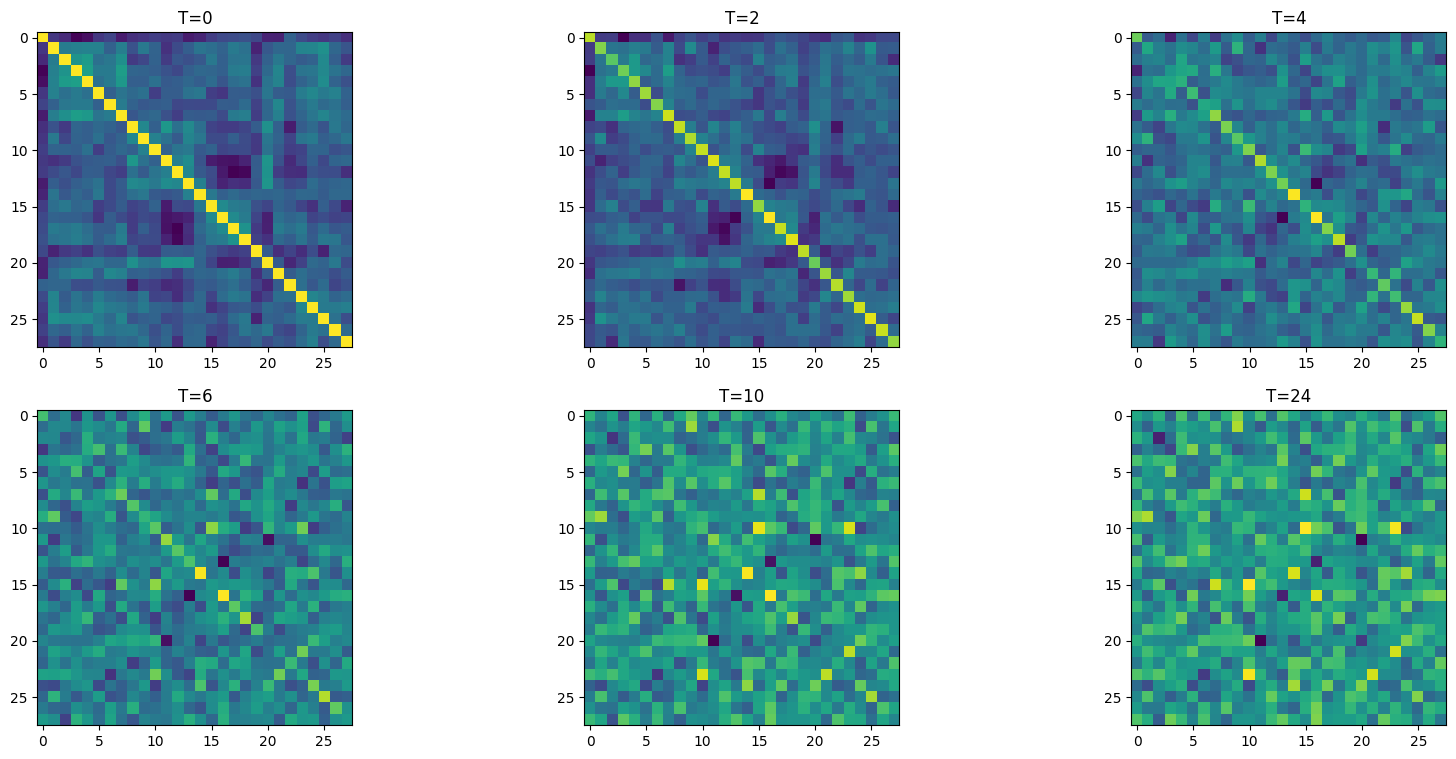

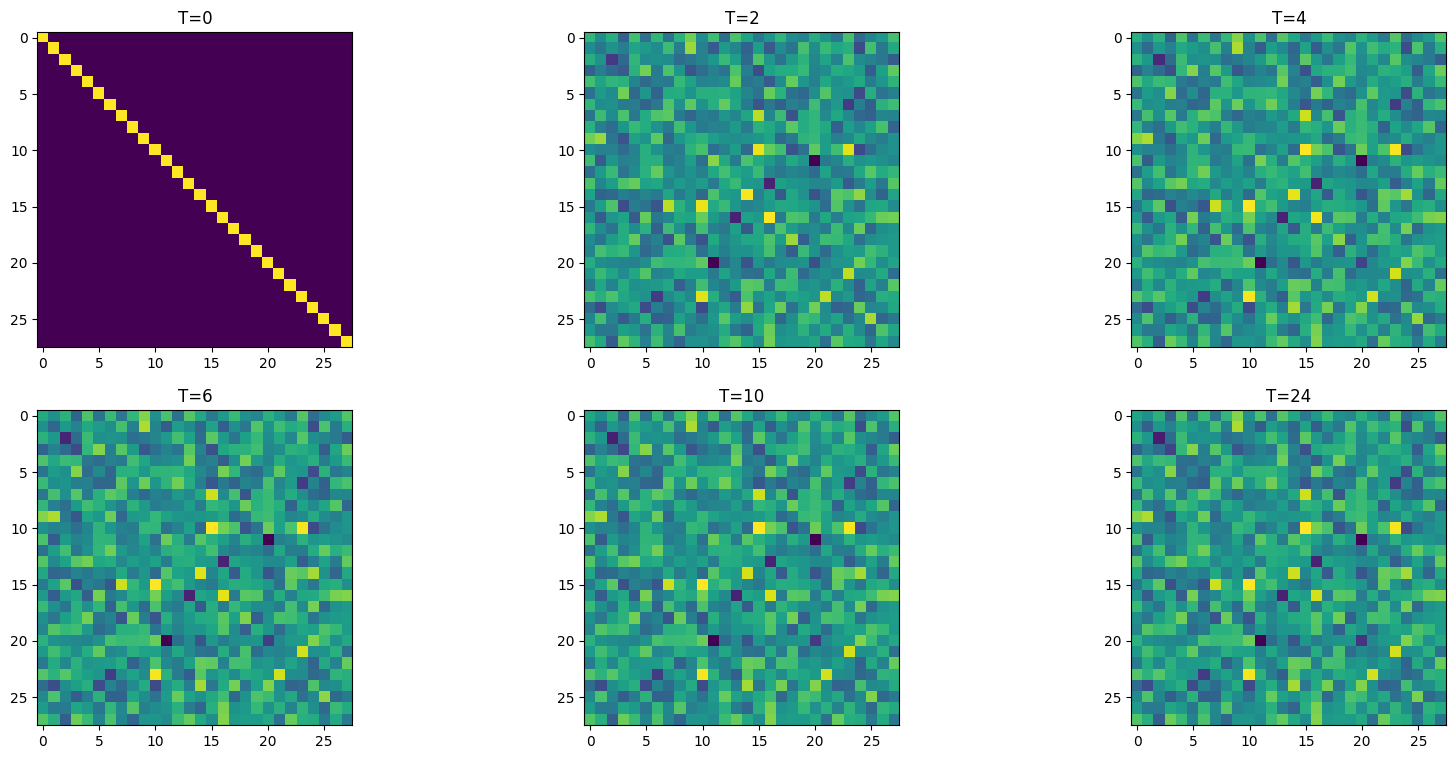

In [9]:
# plot figures
im_ids_plot = [0,2,4,6,10,24]
def plot_mats(mat):
    figs,axs=plt.subplots(2, 3, figsize=(20,9))
    inc = 0
    for im_id,nm in enumerate(mat):
        if im_id not in im_ids_plot: continue
        axs[int((inc)/3)][(inc)%3].imshow(nm)
        axs[int((inc)/3)][(inc)%3].title.set_text(f'T={im_id}')
        inc += 1

plot_mats(noisy_mats)
plot_mats(noise_mats)

In [10]:
# Function for plotting out nx graphs
def plot_network(noisy_matrices):
    nrow,ncol=2,3
    figs,axs=plt.subplots(nrow, ncol, figsize=(20,15))
    inc = 0
    for im_id,noisy_mat in enumerate(noisy_matrices):
        if im_id not in im_ids_plot: continue
        nx_graph = nx.from_numpy_array(np.ceil(noisy_mat))
        degrees = [n for n in nx.degree_centrality(nx_graph).values()]
        nx.draw(nx_graph,pos=None,with_labels=False,node_color=degrees,ax=axs[int((inc)/ncol)][(inc)%ncol],node_size=200,width=.75)
        axs[int((inc)/ncol)][(inc)%ncol].title.set_text(f'T={im_id}')
        inc += 1

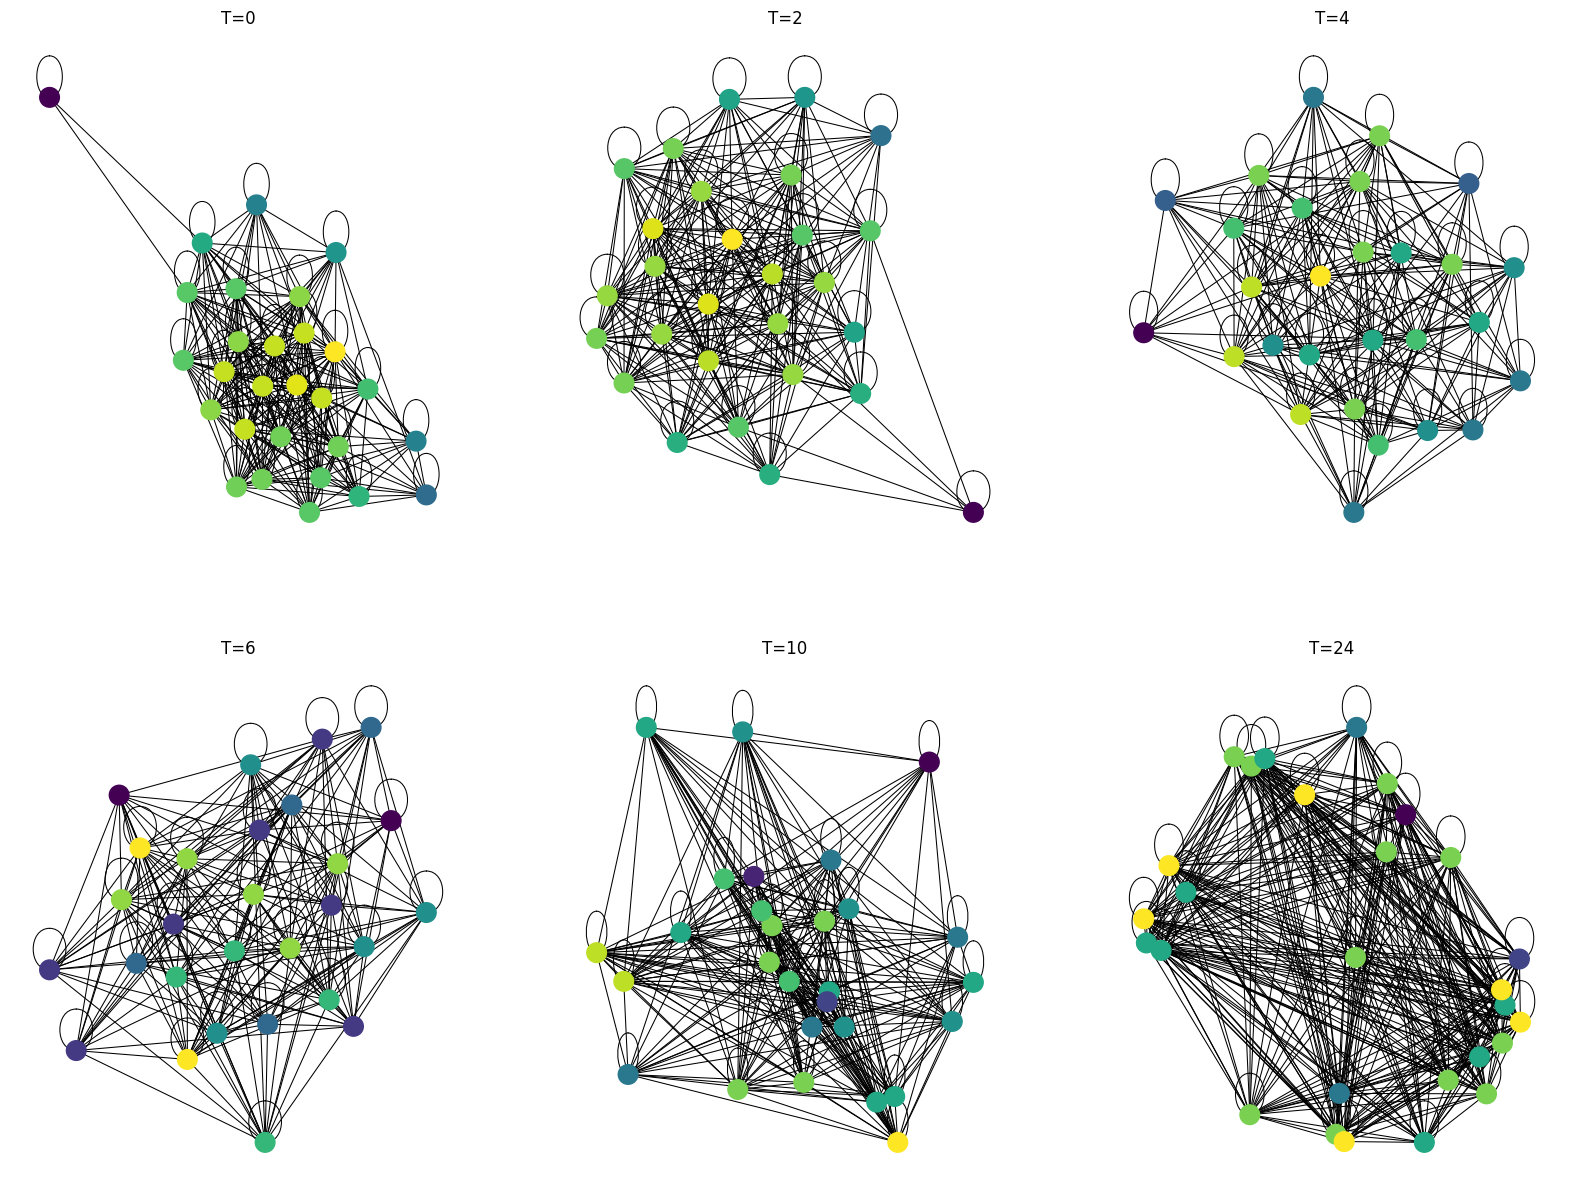

In [11]:
# Plot noisy graph networks
plot_network(noisy_mats)

### Learn on backward diffusion process
(Marianne)

The *learning* of our model is done on the **SPD manifold** (`learning_manifold=SPDMatrices(28)`) 
- The model is fit to one sample at a time that has its noisy samples associated with it.

We adapt our geodesic regression model to learn the geodesics of the **noise matrices**. 

- For a given noisy sample, our model finds the geodesic which produced the noise in the SPD manifold. Our predicted "noise geodesic" is then reversed based on formulas in denoising diffusion to generate our denoised samples. 

We set our learning metric to `SPDEuclideanMetric(28)` for model training and fitting.

### Learning distributions  over manifold of healthy data

Denoising Model (Geodesic regression adaptation) Outline:
$Z = Exp_{\beta_0}(\beta_1 \cdot X) \quad Y = Exp_Z(\epsilon)$ where:
- $X$ is the NOISY input (SPD), $Z$ is the MODEL PREDICTION of the NOISE (symmetric matrix) and $Y$ is the NOISE that will be used for DENOISING conditioned on $Z$ and $\epsilon$
- $Exp$ denotes the Riemannian exponential
- $\beta_0$ is called the intercept and is a point on the manifold
- $\beta_1$ is called the coefficient, and is a tangent vector to the manifold at $\beta_0$
- The model LEARNS $\beta_0,\beta_1$, and it is trains the tangent/intercept to find the mapping between the NOISY INPUT and its RESPECTIVE NOISE
- $\epsilon \sim \mathscr{N}(0,1)$ is a standard Gaussian noise

In [12]:
## Training on healthy brain samples from SPD manifold

# Initialize model
gr_h = DenoisingGeodesic(
    space=learning_manifold, metric=learning_metric, verbose = True,
    center_X=False, method="riemannian", initialization="warm_start",
    max_iter=100, tol=1e-5, init_step_size=1e-6)
gr_h.intercept_ = h_trains[0][-1]  # theta0
gr_h.coef_ = learning_metric.log(h_trains[0][-2], h_trains[0][-1]) # theta1

x_train = np.squeeze(np.linspace(0, T, T))
 
# model fitting: learn noise geodesics on spd manifold of healthy brains
for ind,h_train in enumerate(h_trains):
    gr_h.fit(x_train,h_train,h_cleans[ind])

INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 8.186807515250357e-07
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 1.6707015550403554e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 1.8176678567753897e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 2.00879683801769e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 1.8842705890511797e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 2.0129462340841244e-06
INFO: Toleran

### Learning distributions over manifold of schizophrenic data

In [13]:
## Training on schizophrenic brain samples from SPD manifold

# Initialize model
gr_s = DenoisingGeodesic(
    space=learning_manifold, metric=learning_metric, verbose = True,
    center_X=False, method="riemannian", initialization="warm_start",
    max_iter=100, tol=1e-5, init_step_size=1e-6)
gr_s.intercept_ = s_trains[0][-1]  # theta0
gr_s.coef_ = learning_metric.log(s_trains[0][-2], s_trains[0][-1]) # theta1

s_train = np.squeeze(np.linspace(0, T, T))
 
# model fitting: learn noise geodesics on spd manifold of healthy brains
for ind,s_train in enumerate(s_trains):
    gr_s.fit(x_train,s_train,s_cleans[ind])

INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 6.258363423593325e-07
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 1.3865902403725426e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 1.8104202231098867e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 1.6910118108129935e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 1.975672398134963e-06
INFO: Tolerance threshold reached at iter 99
INFO: Number of gradient evaluations: 98, Number of gradient iterations: 99 loss at termination: 2.016595612150965e-06
INFO: Toleran

### Denoising process (SPD matrix generation)

We now call our model to predict the noise geodesics of both healthy and schizophrenic noisy SPD matrices. With the predicted noise geodesic, we can then denoise our samples back into their original form.

In [14]:
def denoise(x,y_,T,gr):
    '''use model predictions to produce denoised samples'''
    # given clean test example, retrieve noisy samples
    noisy_mats,noise_mats = collect_samples(y_,T,step)
    to_denoise = noisy_mats[-1]
    model_pred = None
    
    for t in range(T)[::-1]:
        # Call model (current image - noise prediction) to get predicted noise
        model_pred = gr._model(np.array([t]), gr.coef_, gr.intercept_)[0]
        model_pred = betas[t] * model_pred

        model_pred = model_pred / sqrt_one_minus_alphas_cumprod[t]

        # tangent from old noisy (spd) to denoised (spd)
        model_diff = learning_metric.log(model_pred, to_denoise)
        model_mean = learning_metric.geodesic(initial_tangent_vec=model_diff, initial_point=to_denoise)(1.0)

        if t==0:
            to_denoise = model_mean
        else:
            symm_noise = np.random.standard_normal(to_denoise.shape)
            symm_noise = np.tril(symm_noise) + np.tril(symm_noise, -1).T
            to_denoise = learning_metric.exp((gs.sqrt(posterior_variance[t]) * symm_noise), model_mean)[0]

    distances = learning_metric.squared_dist(to_denoise, y_)

    return to_denoise, noisy_mats[-1], distances

In [15]:
## We now evaluate our model and visualize two randomly selected samples
h_label = healthy_spd[30]
s_label = schiz_spd[2]

h_preds, noisy_h, distances = denoise(x_train,h_label, T, gr_h)
print('Generated distance to true healthy brain shape:',round(distances[0],2), 
      '\nOriginal noisy distance to true healthy brain shape:',
      round(learning_metric.squared_dist(noisy_h[-1], h_label),2))

s_preds, noisy_s, distances = denoise(x_train,s_label, T, gr_s)
print('Generated distance to true schizophrenic brain shape:',round(distances[0],2), 
      '\nOriginal noisy distance to true healthy brain shape:', 
      round(learning_metric.squared_dist(noisy_s[-1], s_label),2))

Generated distance to true healthy brain shape: 51.49 
Original noisy distance to true healthy brain shape: 51506.38
Generated distance to true schizophrenic brain shape: 37.6 
Original noisy distance to true healthy brain shape: 47160.63


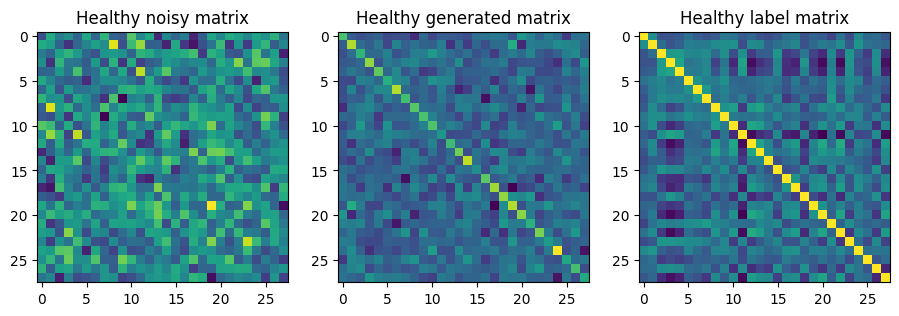

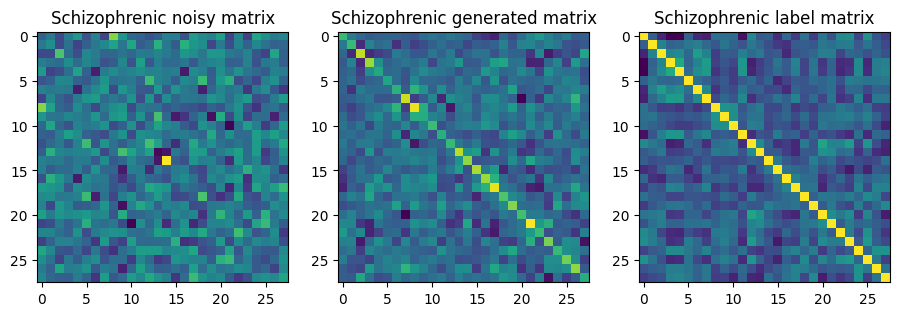

In [16]:
plot_results(h_label,h_preds[-1],noisy_h,'Healthy')
plot_results(s_label,s_preds[-1],noisy_s,'Schizophrenic')

(Marianne & Ryan)

In [17]:
# Plot histogram with respect to SPD Euclidean Metric
def plot_hist(sample1,sample2,bound):
    dist_metric = SPDEuclideanMetric(28)
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16,5))

    healthy_healthy_dist=compute_sqr_dist(sample1, healthy_spd, dist_metric)
    ax0.hist(healthy_healthy_dist,color='seagreen',alpha=0.5, bins=range(0,bound,3), stacked=True)
    healthy_schiz_dist=compute_sqr_dist(sample1, schiz_spd, dist_metric)
    tick_list = range(math.floor(min(healthy_healthy_dist)), math.ceil(max(healthy_healthy_dist))+1)
    #plt.yticks(tick_list)
    ax0.hist(healthy_schiz_dist,range=(0,np.max(healthy_schiz_dist)),color='slateblue',
             bins=range(0,bound,3), alpha=0.5,stacked=True)
    ax0.legend(['healthy','schiz'])
    ax0.title.set_text('Distances of generated network to healthy training set')
    ax0.set_xlabel('SPD Euclidean Metric')
    
    schiz_healthy_dist=compute_sqr_dist(sample2, healthy_spd, dist_metric)
    ax1.hist(schiz_healthy_dist,range=(0,np.max(schiz_healthy_dist)),color='seagreen',
             bins=range(0,bound,3), alpha=0.5,stacked=True)
    schiz_schiz_dist=compute_sqr_dist(sample2, schiz_spd, dist_metric)
    ax1.hist(schiz_schiz_dist,range=(0,np.max(schiz_schiz_dist)),
             bins=range(0,bound,3),color='slateblue',alpha=0.5,stacked=True)
    ax1.legend(['healthy','schiz'])
    ax1.title.set_text('Distances of generated network to schizophrenic training set')
    ax1.set_xlabel('SPD Euclidean Metric')
    

    plt.show()
    print('Average distance between:')
    print('  Predicted healthy and ground truth healthy brain:', round(sum(healthy_healthy_dist)/len(healthy_healthy_dist),2))
    print('  Predicted healthy and ground truth schiz brain:', round(sum(healthy_schiz_dist)/len(healthy_schiz_dist),2))
    print('  Predicted schiz and ground truth healthy brain:', round(sum(schiz_healthy_dist)/len(schiz_healthy_dist),2))
    print('  Predicted schiz and ground truth schiz brain:', round(sum(schiz_schiz_dist)/len(schiz_schiz_dist),2))

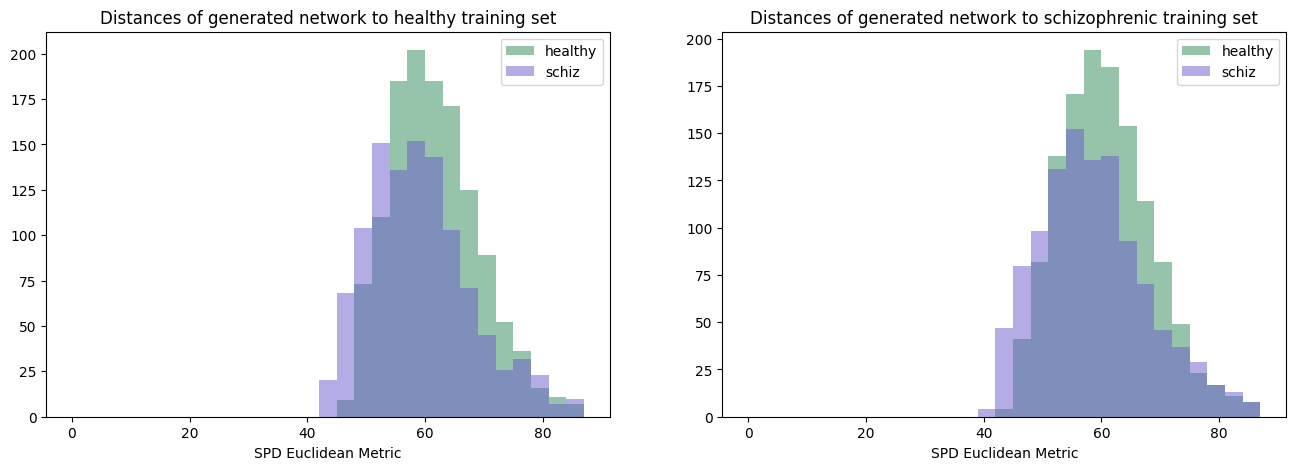

Average distance between:
  Predicted healthy and ground truth healthy brain: 62.03
  Predicted healthy and ground truth schiz brain: 60.08
  Predicted schiz and ground truth healthy brain: 61.07
  Predicted schiz and ground truth schiz brain: 59.41


In [18]:
plot_hist(h_preds[-1],s_preds[-1],90)

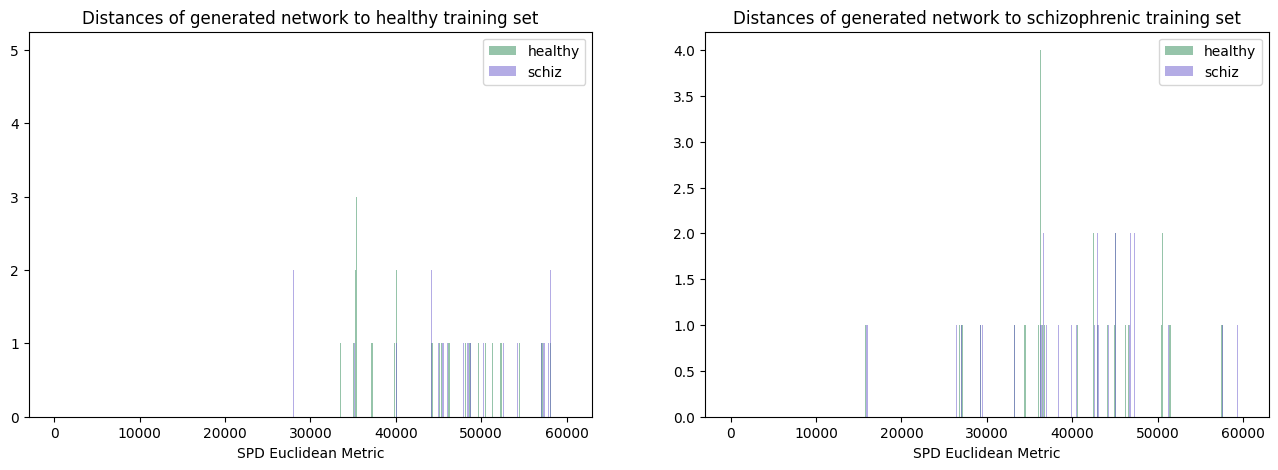

Average distance between:
  Predicted healthy and ground truth healthy brain: 50945.64
  Predicted healthy and ground truth schiz brain: 50950.93
  Predicted schiz and ground truth healthy brain: 43008.9
  Predicted schiz and ground truth schiz brain: 43022.44


In [19]:
plot_hist(noisy_h,noisy_s,60000)

### Similarity of generated samples to training set
We also visualize our generated healthy and schizophrenic brain networks to their respective ground truths.
(Marianne)

In [20]:
adj_label, adj_pred, adj_noisy = np.ceil(h_label),np.ceil(h_preds[0]),np.ceil(noisy_h)
g_label = nx.from_numpy_array(adj_label)
g_pred = nx.from_numpy_array(adj_pred)
g_noisy = nx.from_numpy_array(adj_noisy)

In [21]:
def plot_graphs_spatial(nx_graph, subgraph_id, title):
    """Plots spatial graphs.
    
    Plots graph network with title and appropriate subgraph.
    
    Parameters
        ----------
        nx_graph : graph object
            Graph object used for plotting.
        subgraph_id : int
            ID for subgraph plot.
        title : string
            Title of plot.
    """
    plt.subplot(subgraph_id)
    degrees = [n for n in nx.degree_centrality(nx_graph).values()]
    nx.draw(nx_graph,pos=None,with_labels=False,node_color=degrees,node_size=200,width=.75)
    plt.title(title)

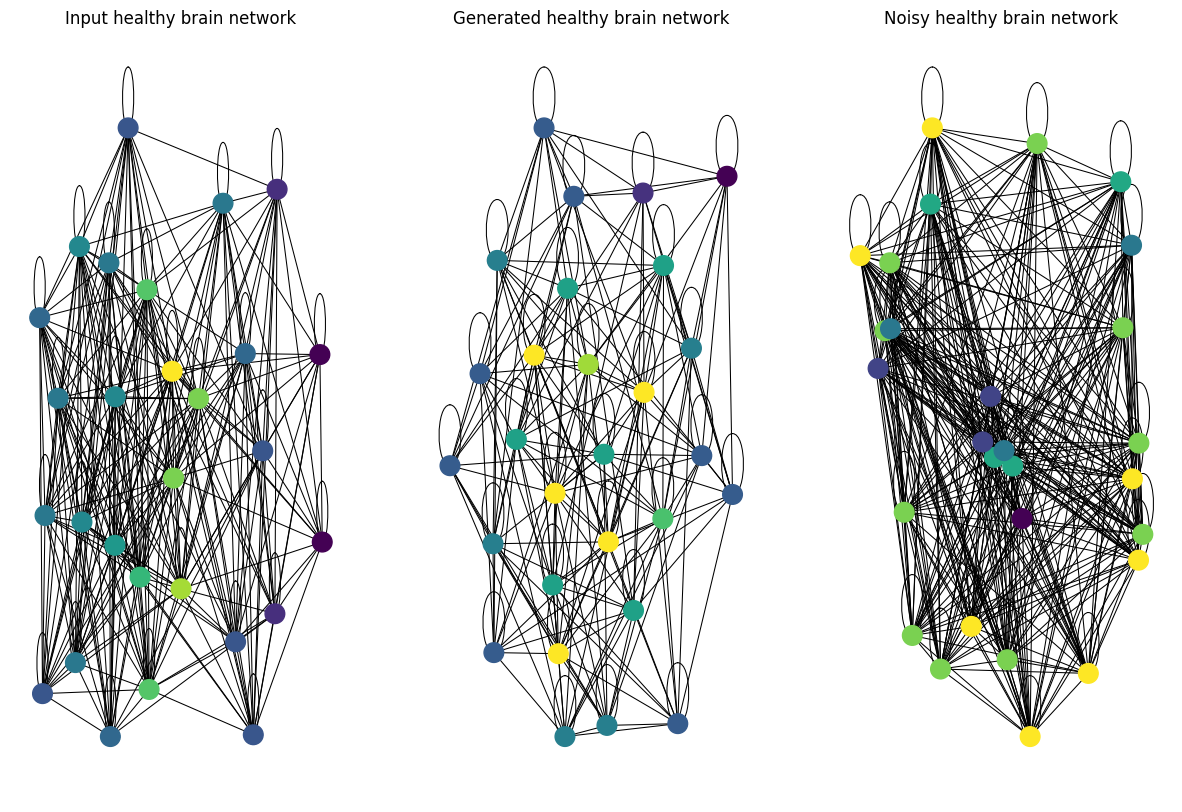

In [22]:
plt.figure(figsize=(15,10))
plot_graphs_spatial(g_label,131,"Input healthy brain network")
plot_graphs_spatial(g_pred,132,"Generated healthy brain network")
plot_graphs_spatial(g_noisy,133,"Noisy healthy brain network")

In [23]:
adj_label, adj_pred, adj_noisy = np.ceil(s_label),np.ceil(s_preds[0]),np.ceil(noisy_s)
g_label = nx.from_numpy_array(adj_label)
g_pred = nx.from_numpy_array(adj_pred)
g_noisy = nx.from_numpy_array(adj_noisy)

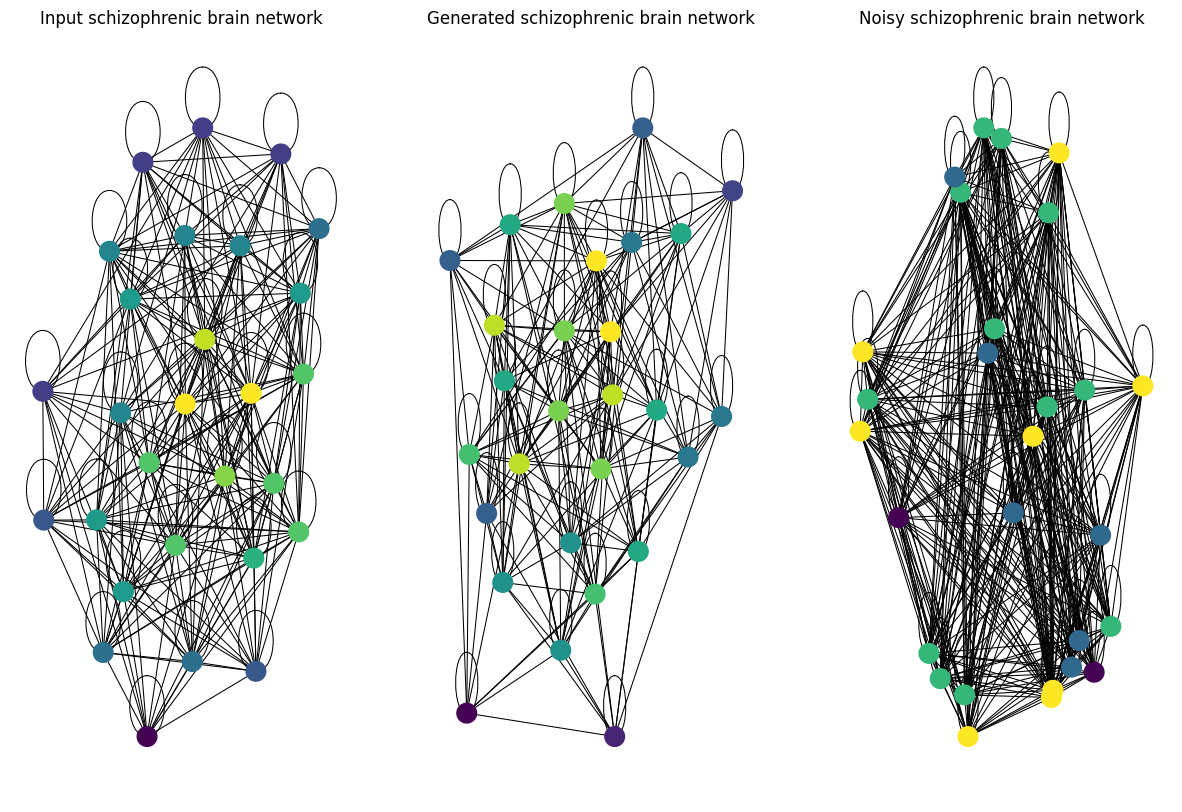

In [24]:
plt.figure(figsize=(15,10))
plot_graphs_spatial(g_label,131,"Input schizophrenic brain network")
plot_graphs_spatial(g_pred,132,"Generated schizophrenic brain network")
plot_graphs_spatial(g_noisy,133,"Noisy schizophrenic brain network")

# Conclusion and future steps:
(Ryan)
- Our model performs decent in general denoising of noisy FNC data, but still needs to improve its understanding of the distributions between healthy and schizophrenic brain networks.
- Improvements that can be made:
    - More finetuning of model (`T`, `max_iter`, `tol`,...)
    - Increase amount of data to train/test
    - Implement more `learning_metric` options

References:

[1] https://www.who.int/news-room/fact-sheets/detail/schizophrenia

[2] https://www.kaggle.com/competitions/mlsp-2014-mri/overview

[3] Jonathan Ho, Ajay Jain, and Pieter Abbeel. Denoising diffusion probabilistic models. In H. Larochelle, M. Ranzato, R. Hadsell, M.F. Balcan, and H. Lin (eds.), Advances in Neural Information Processing Systems, volume 33, pp. 6840–6851. Curran Asso- ciates, Inc., 2020. URL https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf.